Import libraries:

In [119]:
import numpy as np
from scipy.stats import mode
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
import theano
import pymc3 as pm
import lasagne
import theano.tensor as T

floatX = theano.config.floatX

In [51]:
import sklearn
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons, make_blobs, make_circles
from sklearn.metrics import accuracy_score

Some global variables:

In [89]:
ADVI_ITERS = 50000
N_SAMPLES = 500

# Bayesian Neural Networks in PyMC3

In [347]:
class PriorWeights(object):
    def __init__(self, mode='W', prior='gauss', **params):
        self.count = 0
        self.prior = prior
        self.mode = mode
        params.setdefault('std', 1.)
        params.setdefault('hyper', None)
        self.params = params
    def __call__(self, shape):
        self.count += 1
        if self.params['hyper'] is None:
            std = self.params['std']
        elif self.params['hyper'] == 'cauchy':
            std = pm.HalfCauchy('hyper_%s%d' % (self.mode, self.count), beta=1.)
        elif self.params['hyper'] == 'normal':
            std = pm.HalfNormal('hyper_%s%d' % (self.mode, self.count), mu=0., sd=1.)
        elif self.params['hyper'] == 'flat':
            std = pm.Flat()
        if self.prior == 'gauss':
            return pm.Normal('%s%d' % (self.mode, self.count), mu=0, sd=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        if self.prior == 'laplace': 
            return pm.Laplace('%s%d' % (self.mode, self.count), mu=0, b=std, 
                         testval=np.random.normal(size=shape).astype(np.float64),
                         shape=shape)
        elif self.prior == 'flat':
            return pm.Flat('%s%d' % (self.mode, self.count), 
                           testval=np.random.normal(size=shape).astype(np.float64), 
                           shape=shape)

In [297]:
def build_ann(prior_b, prior_W, input_var, target_var, 
              input_shape, params=[5, 5, 2]):
    with pm.Model() as neural_network:
        l_in = lasagne.layers.InputLayer(shape=input_shape,
                                         input_var=input_var)
        n_hid1, n_hid2, n_classes = params
        l_hid1 = lasagne.layers.DenseLayer(
            l_in, num_units=n_hid1,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=prior_b,
            W=prior_W
        )
        l_hid2 = lasagne.layers.DenseLayer(
            l_hid1, num_units=n_hid2,
            nonlinearity=lasagne.nonlinearities.tanh,
            b=prior_b,
            W=prior_W
        )
        l_out = lasagne.layers.DenseLayer(
            l_hid2, num_units=n_classes,
            nonlinearity=lasagne.nonlinearities.softmax,
            b=prior_b,
            W=prior_W
        )

        prediction = lasagne.layers.get_output(l_out)
        out = pm.Categorical('out', prediction, observed=target_var, 
                             total_size=y_train.shape[0])
        
#         out = pm.Bernoulli('out', prediction,
#                            observed=target_var, total_size=y_train.shape[0])
    
    return neural_network

In [298]:
def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data[ixs]

In [299]:
def get_prediction(samples_proba):
    return mode(np.argmax(sample_proba(X_test, 500), 
                          axis=-1), 
                axis=0).mode[0]

# Data generation

## Moons 

In [300]:
X, y = make_moons(noise=0.3, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
input_shape = list(X_train.shape)
input_shape[0] = None
input_shape = tuple(input_shape)

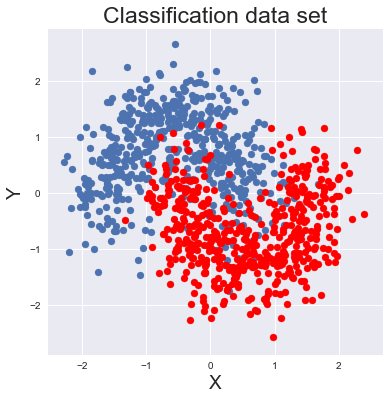

In [301]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], color='r', label='Class 1')
ax.set_xlabel('X', fontsize=19)
ax.set_ylabel('Y', fontsize=19)
ax.set_title('Classification data set', fontsize=23)
plt.show()

In [344]:
minibatch_X = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(y_train))
neural_network_minibatch = build_ann(PriorWeights(mode='b', prior='flat'), 
                                     PriorWeights(mode='W', prior='gauss'),
                                     minibatch_X, minibatch_y, 
                                     input_shape, params=[5, 5, 2])
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(ADVI_ITERS, method=inference)

Average Loss = 146.87: 100%|███████████████████████████████████████████████████| 50000/50000 [00:15<00:00, 3226.45it/s]
Finished [100%]: Average Loss = 146.99


In [345]:
x = T.matrix('X')
n = T.iscalar('n')
theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network_minibatch.out.distribution.p, 
                                   size=n,
                                   more_replacements={minibatch_X:x})
sample_proba = theano.function([x, n], _sample_proba)

In [346]:
y_pred = get_prediction(sample_proba(X_test, N_SAMPLES))
accuracy_score(y_test, y_pred)

0.90200000000000002

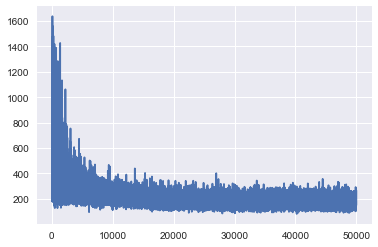

In [323]:
plt.plot(inference.hist[10:])

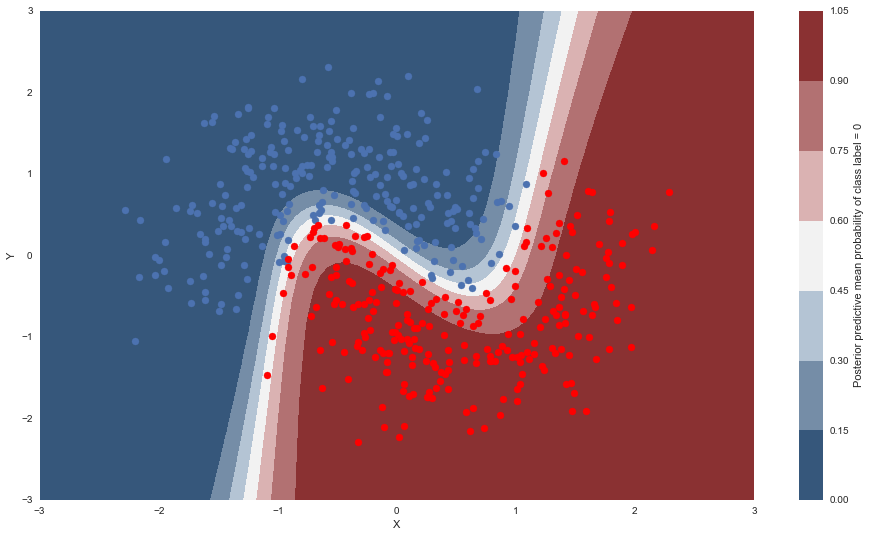

In [324]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc[:, :, 1].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_pred==0, 0], X_test[y_pred==0, 1])
ax.scatter(X_test[y_pred==1, 0], X_test[y_pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

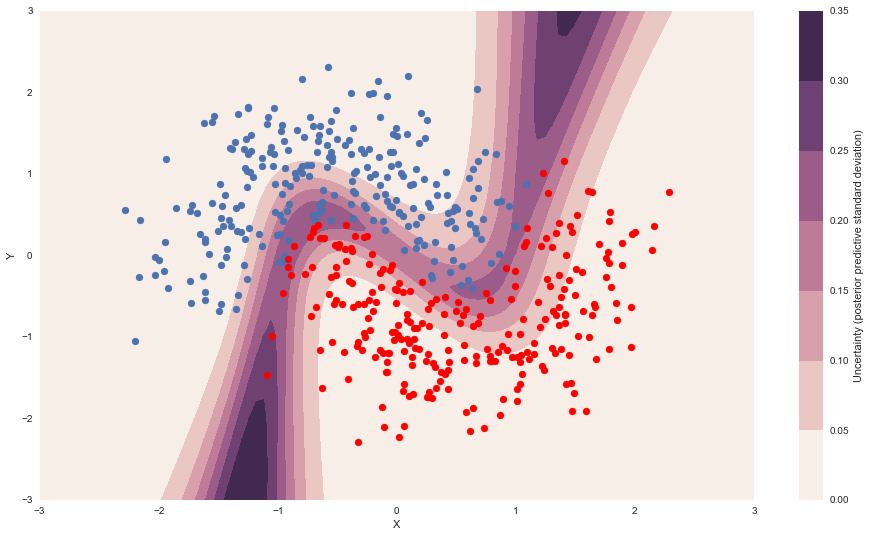

In [325]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc[:, :, 1].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_pred==0, 0], X_test[y_pred==0, 1])
ax.scatter(X_test[y_pred==1, 0], X_test[y_pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

## Circles

In [245]:
X, y = make_circles(noise=0.1, random_state=0, n_samples=5000, factor=0.8)
X = scale(X)
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7)
input_shape = list(X_train.shape)
input_shape[0] = None
input_shape = tuple(input_shape)

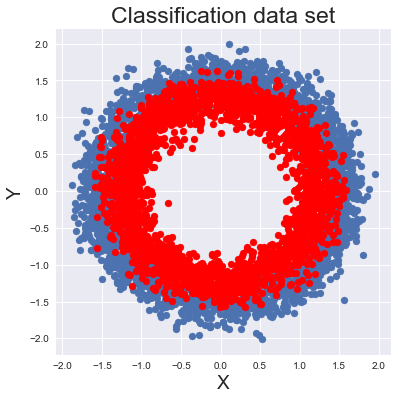

In [246]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], color='r', label='Class 1')
ax.set_xlabel('X', fontsize=19)
ax.set_ylabel('Y', fontsize=19)
ax.set_title('Classification data set', fontsize=23)
plt.show()

In [247]:
minibatch_X = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(y_train))
neural_network_minibatch = build_ann(GaussWeightsHierarchical_b(), 
                                     GaussWeightsHierarchical_W(),
                                     minibatch_X, minibatch_y, 
                                     input_shape, params=[5, 5, 2])
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(ADVI_ITERS, method=inference)

Average Loss = 1,003.8: 100%|██████████████████████████████████████████████████| 50000/50000 [00:22<00:00, 2256.78it/s]
Finished [100%]: Average Loss = 1,003.8


In [248]:
x = T.matrix('X')
n = T.iscalar('n')
theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network_minibatch.out.distribution.p, 
                                   size=n,
                                   more_replacements={minibatch_X:x})
sample_proba = theano.function([x, n], _sample_proba)

In [249]:
y_pred = get_prediction(sample_proba(X_test, N_SAMPLES))
accuracy_score(y_test, y_pred)

0.64314285714285713

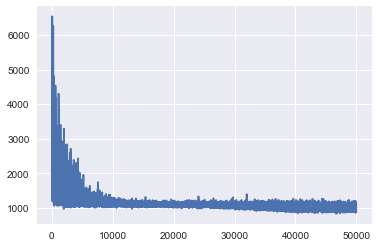

In [250]:
plt.plot(inference.hist[10:])

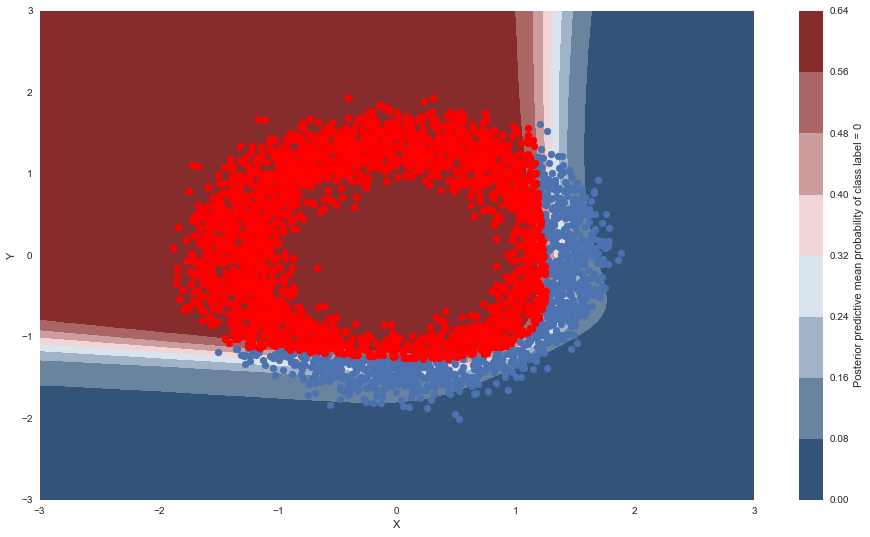

In [251]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc[:, :, 1].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_pred==0, 0], X_test[y_pred==0, 1])
ax.scatter(X_test[y_pred==1, 0], X_test[y_pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

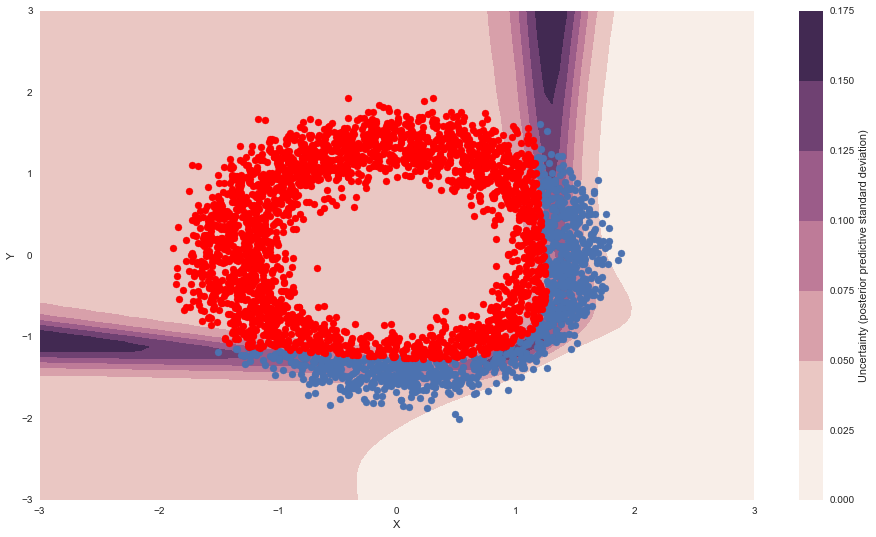

In [252]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc[:, :, 1].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[y_pred==0, 0], X_test[y_pred==0, 1])
ax.scatter(X_test[y_pred==1, 0], X_test[y_pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

In [222]:
trace = approx.sample(draws=5000)

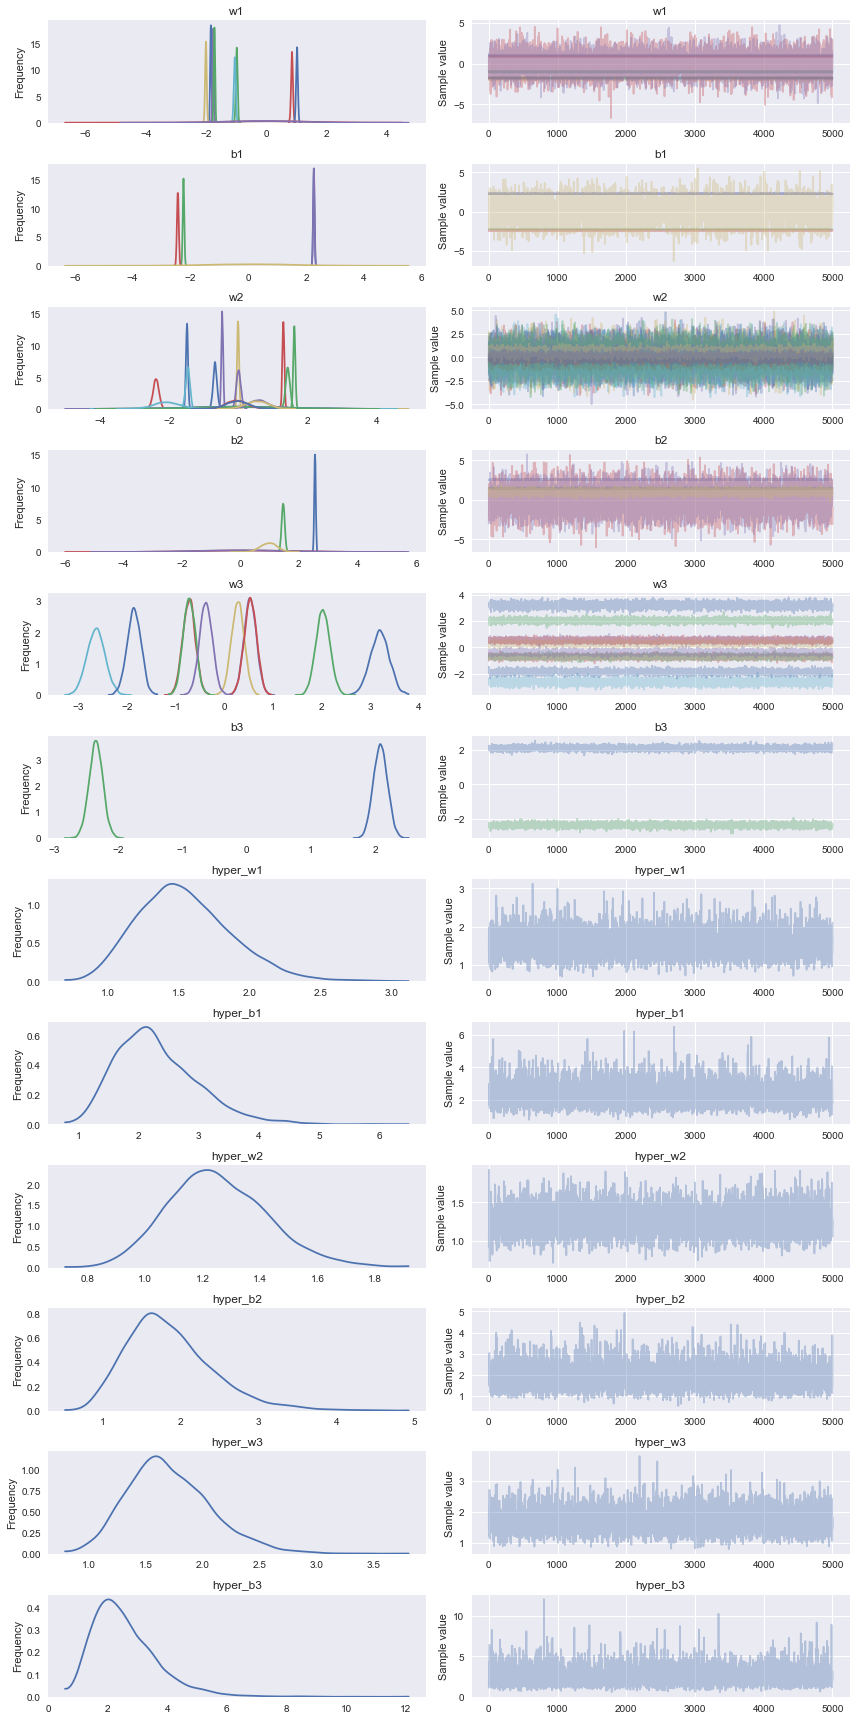

In [223]:
pm.traceplot(trace);

## Blobs

In [111]:
X, y = make_blobs(cluster_std=0.87, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
y = y.astype(floatX)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5)
input_shape = list(X_train.shape)
input_shape[0] = None
input_shape = tuple(input_shape)

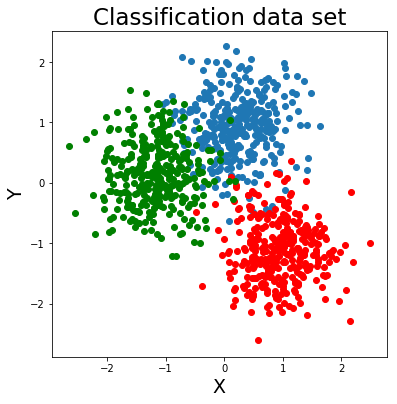

In [112]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(X[y==0, 0], X[y==0, 1], label='Class 0')
ax.scatter(X[y==1, 0], X[y==1, 1], color='r', label='Class 1')
ax.scatter(X[y==2, 0], X[y==2, 1], color='g', label='Class 2')
ax.set_xlabel('X', fontsize=19)
ax.set_ylabel('Y', fontsize=19)
ax.set_title('Classification data set', fontsize=23)
plt.show()

In [113]:
minibatch_X = pm.generator(create_minibatch(X_train))
minibatch_y = pm.generator(create_minibatch(y_train))
neural_network_minibatch = build_ann(GaussWeights_b(), GaussWeights_W(),
                                     minibatch_X, minibatch_y, 
                                     input_shape, params=[5, 5, 3])
with neural_network_minibatch:
    inference = pm.ADVI()
    approx = pm.fit(ADVI_ITERS, method=inference)

Average Loss = 157.1: 100%|████████████████████████████████████████████████████| 50000/50000 [00:16<00:00, 3028.35it/s]
Finished [100%]: Average Loss = 157.09


In [114]:
x = T.matrix('X')
n = T.iscalar('n')
theano.config.compute_test_value = 'off'
_sample_proba = approx.sample_node(neural_network_minibatch.out.distribution.p, 
                                   size=n,
                                   more_replacements={minibatch_X:x})
sample_proba = theano.function([x, n], _sample_proba)

In [115]:
y_pred = get_prediction(sample_proba(X_test, N_SAMPLES))
accuracy_score(y_test, y_pred)

0.95199999999999996

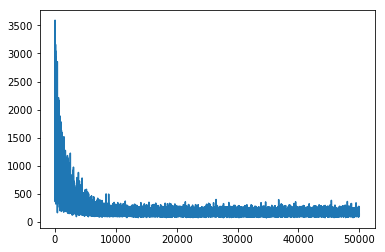

In [116]:
plt.plot(inference.hist[10:])

ValueError: cannot reshape array of size 30000 into shape (100,100)

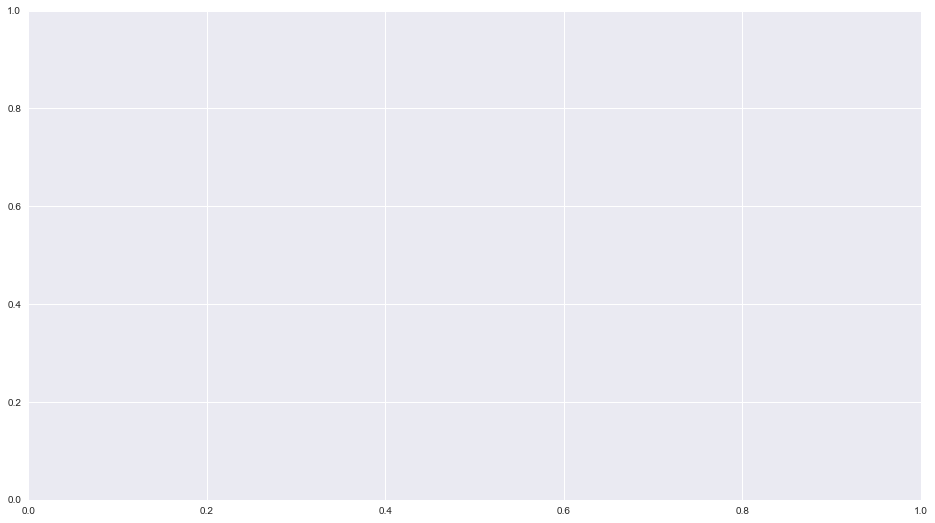

In [122]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)
ppc = sample_proba(grid_2d, 500)

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(16, 9))
contour = ax.contourf(grid[0], grid[1], ppc.mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');